In [27]:
# Data Analysis library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# kmeans clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
kepler = pd.read_csv('data/kepler_data.csv')
kepler.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## Preprocessing of data

In [3]:
kepler.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2294 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

In [4]:
kepler.isnull().sum()

rowid                   0
kepid                   0
kepoi_name              0
kepler_name          7270
koi_disposition         0
koi_pdisposition        0
koi_score            1510
koi_fpflag_nt           0
koi_fpflag_ss           0
koi_fpflag_co           0
koi_fpflag_ec           0
koi_period              0
koi_period_err1       454
koi_period_err2       454
koi_time0bk             0
koi_time0bk_err1      454
koi_time0bk_err2      454
koi_impact            363
koi_impact_err1       454
koi_impact_err2       454
koi_duration            0
koi_duration_err1     454
koi_duration_err2     454
koi_depth             363
koi_depth_err1        454
koi_depth_err2        454
koi_prad              363
koi_prad_err1         363
koi_prad_err2         363
koi_teq               363
koi_teq_err1         9564
koi_teq_err2         9564
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_model_snr         363
koi_tce_plnt_num      346
koi_tce_delivname     346
koi_steff   

In [5]:
kepler['koi_disposition'].value_counts()


FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: koi_disposition, dtype: int64

In [6]:
kepler['koi_pdisposition'].value_counts()

FALSE POSITIVE    5068
CANDIDATE         4496
Name: koi_pdisposition, dtype: int64

In [7]:
# remove the unnecessary columns
kepler = kepler.drop(['rowid', 'kepid', 'kepoi_name', 'kepler_name',
                     'koi_pdisposition', 'koi_score',
                     'koi_teq_err1', 'koi_teq_err2','koi_teq_err1', 'koi_teq_err2'], axis=1)



In [8]:
# remove the CANDIDATE drom the koi_disposition
kepler = kepler[kepler['koi_disposition'] != 'CANDIDATE']
# change nan values with the mean of the columns 
kepler['koi_tce_delivname'] = kepler['koi_tce_delivname'].fillna(kepler['koi_tce_delivname'].mode()[0])
for col in kepler.columns[kepler.isna().sum() > 0]:
    kepler[col].fillna(kepler[col].mean(), inplace=True)

#one-hot encoding for the categorical columns
delivname_dummies = pd.get_dummies(kepler['koi_tce_delivname'], prefix='delivname', drop_first=True)
kepler = pd.concat([kepler, delivname_dummies], axis=1)
kepler = kepler.drop(['koi_tce_delivname'], axis=1)

# change to 0 and 1 
kepler['koi_disposition'] = kepler['koi_disposition'].map({'CONFIRMED': 1, 'FALSE POSITIVE': 0})

# split the data into x and y columns
x = kepler.drop(['koi_disposition'], axis=1)
y = kepler['koi_disposition']



# split into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, shuffle=True)

# scale 
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)



In [9]:
x_train

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,delivname_q1_q17_dr24_tce,delivname_q1_q17_dr25_tce
8235,-0.573066,1.542789,-0.583589,-0.431874,-0.476250,-0.253961,0.253961,-0.522234,-0.431417,0.431417,...,-0.430703,1.287012,-0.212051,-0.348611,0.268298,-0.782666,0.522669,-0.726733,-0.170704,0.344399
703,-0.573066,-0.648177,-0.583589,-0.431874,-0.461878,-0.252540,0.252540,0.118395,-0.247971,0.247971,...,-0.599816,1.003282,-0.181405,-0.354420,0.276648,0.760704,-0.367571,1.211083,-0.170704,0.344399
4065,-0.573066,-0.648177,-0.583589,-0.431874,-0.476072,-0.253517,0.253517,-0.520748,-0.266878,0.266878,...,-0.430703,1.348692,-0.242096,-0.378819,0.272473,0.238323,-0.063030,0.689608,-0.170704,0.344399
1132,-0.573066,1.542789,-0.583589,-0.431874,-0.457449,-0.253742,0.253742,-0.395880,-0.412171,0.412171,...,-0.538320,-0.810119,-0.143749,-0.061635,0.230722,-1.937494,1.285590,0.394862,-0.170704,0.344399
5483,-0.573066,-0.648177,-0.583589,-0.431874,-0.401226,-0.249949,0.249949,-0.519239,-0.291118,0.291118,...,0.015142,-0.353685,-0.157369,-0.146450,0.194816,0.968723,0.363079,0.493347,-0.170704,0.344399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,-0.573066,1.542789,-0.583589,-0.431874,-0.408532,-0.252597,0.252597,0.286986,-0.382259,0.382259,...,-0.238528,-0.329013,-0.169788,-0.180143,0.223206,0.817046,-1.038985,0.922713,-0.170704,0.344399
6783,1.745000,-0.648177,-0.583589,-0.431874,2.467980,0.854988,-0.854988,2.266541,0.503462,-0.503462,...,-0.438390,-2.623521,-0.109297,0.419368,0.203166,-1.602850,1.659632,-0.367511,-0.170704,-2.903608
5231,-0.573066,1.542789,-0.583589,-0.431874,-0.427981,-0.252990,0.252990,-0.478397,-0.370624,0.370624,...,-0.153971,0.707217,-0.183007,-0.312594,0.237402,1.459376,0.154761,2.217188,-0.170704,0.344399
258,-0.573066,-0.648177,-0.583589,-0.431874,-0.338315,-0.247524,0.247524,-0.490763,-0.314873,0.314873,...,-0.346146,1.422708,-0.175396,-0.385790,0.262452,-0.540205,0.112025,0.859655,-0.170704,0.344399


In [10]:
y_train.value_counts()

0    3495
1    1626
Name: koi_disposition, dtype: int64

## Training the models

In [11]:


models = {
    "Logistic Regression": LogisticRegression(),
    "      Decision Tree": DecisionTreeClassifier(),
    "     Neural Network": MLPClassifier(),
    "      Random Forest": RandomForestClassifier(),
    "  Gradient Boosting": GradientBoostingClassifier(),
    "            XGBoost": XGBClassifier(eval_metric='logloss'),
    "           LightGBM": LGBMClassifier(),
    "           CatBoost": CatBoostClassifier(verbose=0)
}

for name, model in models.items():
    model.fit(x_train, y_train)
    print(f'{name} trained.')

Logistic Regression trained.
      Decision Tree trained.
     Neural Network trained.
      Random Forest trained.
  Gradient Boosting trained.
            XGBoost trained.
           LightGBM trained.
           CatBoost trained.


In [21]:
for name, model in models.items():
    y_pred = model.predict(x_test)
    print(f'{name} accuracy: {accuracy_score(y_test, y_pred):.4f} | precision: {precision_score(y_test, y_pred):.4f} | recall: {recall_score(y_test, y_pred):.4f} | f1 score: {f1_score(y_test, y_pred):.4f}')



Logistic Regression accuracy: 0.9872 | precision: 0.9747 | recall: 0.9835 | f1 score: 0.9791
      Decision Tree accuracy: 0.9800 | precision: 0.9574 | recall: 0.9775 | f1 score: 0.9674
     Neural Network accuracy: 0.9904 | precision: 0.9807 | recall: 0.9880 | f1 score: 0.9843
      Random Forest accuracy: 0.9886 | precision: 0.9938 | recall: 0.9685 | f1 score: 0.9810
  Gradient Boosting accuracy: 0.9936 | precision: 0.9880 | recall: 0.9910 | f1 score: 0.9895
            XGBoost accuracy: 0.9945 | precision: 0.9925 | recall: 0.9895 | f1 score: 0.9910
           LightGBM accuracy: 0.9954 | precision: 0.9940 | recall: 0.9910 | f1 score: 0.9925
           CatBoost accuracy: 0.9954 | precision: 0.9940 | recall: 0.9910 | f1 score: 0.9925


In [46]:
kmeans = KMeans(n_clusters=2, random_state=1)
kmeans.fit(x_train)


KMeans(n_clusters=2, random_state=1)

In [47]:
cluster = kmeans.predict(x_train)
cluster

array([1, 1, 1, ..., 1, 1, 0], dtype=int32)

In [58]:
pca = PCA(n_components=2)
reduced_x_train = pca.fit_transform(x_train)
reduced_x_train = pd.DataFrame(reduced_x_train, columns=['PCA1', 'PCA2'])
reduced_x_train

,PCA1,PCA2
0,-1.810970,-0.755001
1,-0.853693,-1.322251
2,-1.234761,-1.234072
3,-1.168824,-0.619234
4,-0.815221,-0.671508
...,...,...
5116,-1.006213,-0.681456
5117,4.222256,0.082623
5118,-1.378934,-1.046887
5119,-1.147740,-1.368278


In [54]:
center_clusters = pca.transform(kmeans.cluster_centers_)
center_clusters

array([[ 5.39233394,  0.63825355, -0.14415962],
       [-0.71158783, -0.08422577,  0.01902372]])

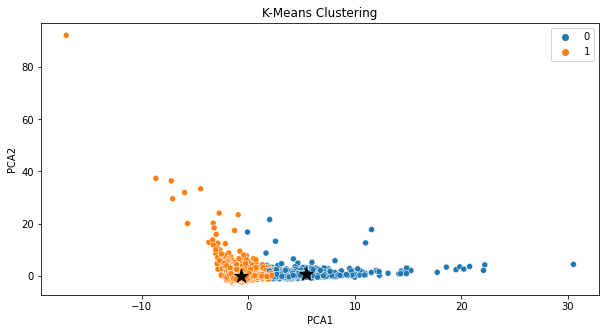

In [60]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue=cluster, data=reduced_x_train)
plt.scatter(center_clusters[:, 0], center_clusters[:, 1], c='black', s=200, marker='*')
plt.title('K-Means Clustering')
plt.show()